In [1]:
import qutip
import jax
import jax.numpy as jnp
import optax

from qurveros import losses, barqtools, plottools
from qurveros.optspacecurve import BarqCurve
from qurveros.qubit_bench import simulator, noise_experiments, quantumtools
import qurveros.plot_configs

import matplotlib
matplotlib.rcParams['figure.dpi'] = 150

In this example, we will design a Hadamard gate. For a detailed introduction
into optimizing pulses using BARQ, consult the associated paper and the
`Xgate_design_barq` example.

The design choices are similar to the ones used for the X-gate.

In [2]:
u_target = 1/jnp.sqrt(2)*qutip.Qobj([[1,1],[1,-1]])
adj_target = quantumtools.calculate_adj_rep(u_target)

In [3]:
u_target

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]

The PGF used in this example is identical to the Xgate design example.

In [4]:
@jax.jit
def hadamard_pgf_mod(pgf_params, input_points):

    pgf_params_mod = pgf_params.copy()

    norm_set = pgf_params_mod['norm_value']

    pgf_params_mod['left_tangent_fix'] = norm_set
    pgf_params_mod['left_tangent_aux'] = norm_set

    pgf_params_mod['left_binormal_fix'] = norm_set
    pgf_params_mod['right_binormal_fix'] = norm_set

    pgf_params_mod['right_tangent_aux'] = norm_set
    pgf_params_mod['right_tangent_fix'] = norm_set

    pgf_params_mod['left_binormal_aux'] = pgf_params_mod['right_binormal_aux']

    return pgf_params_mod

In [5]:
barqcurve = BarqCurve(adj_target=adj_target,
                      n_free_points=10,
                      pgf_mod=hadamard_pgf_mod)

barqcurve.prepare_optimization_loss(
        [losses.tantrix_zero_area_loss, 1], # Multiplicative driving field error suppression (first order).
        [losses.max_amp_loss, 1e-2]) # Minimization of the maximum amplitude.

In [6]:
init_pgf = barqtools.get_default_pgf_params_dict()
init_pgf['norm_value'] = 0.5

barqcurve.initialize_parameters(seed=729, 
                                init_pgf_params=init_pgf)

In [7]:
params_labels = jax.tree.map(lambda x : True, barqcurve.params)
params_labels['pgf_params']['norm_value'] = False

optimizer = optax.multi_transform({
     True: optax.adam(learning_rate=0.001),
     False: optax.set_to_zero()}, param_labels = params_labels)

In [8]:
barqcurve.optimize(optimizer, max_iter=50000) 


Optimizing parameters:	100.00%


In [9]:
barqcurve.evaluate_frenet_dict()
barqcurve.evaluate_control_dict()
barqcurve.evaluate_robustness_properties()
barqcurve.get_robustness_properties()

|       closed_test       : 	 0.0000e+00
|     curve_area_test     : 	 4.6033e-03
|    tantrix_area_test    : 	 1.8541e-05
|           CFI           : 	 3.6085e-02


-2.00809739517636


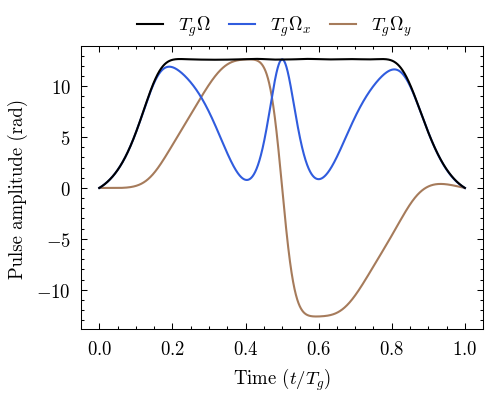

In [10]:
barqcurve.plot_fields('compact')
print(barqcurve.get_control_dict()['delta'][0])

In [11]:
simulator.simulate_control_dict(barqcurve.get_control_dict(), u_target)

{'adj_final': array([[ 2.13234985e-12, -9.34125152e-07,  1.00000000e+00],
        [ 6.06308850e-12, -1.00000000e+00, -9.34125152e-07],
        [ 1.00000000e+00,  6.06309049e-12, -2.13223883e-12]]),
 'adj_target': array([[ 0.,  0.,  1.],
        [ 0., -1.,  0.],
        [ 1.,  0.,  0.]]),
 'avg_gate_fidelity': 0.9999999999998407,
 'u_final': array([[ 3.30265258e-07-0.70710678j,  3.30260971e-07-0.70710678j],
        [-3.30260971e-07-0.70710678j,  3.30265258e-07+0.70710678j]])}

In [12]:
multi_source_dict = noise_experiments.simult_source_experiment(
    barqcurve.get_control_dict(), u_target)

Static additive dephasing and multiplicative driving field experiment



Multiplicative driving field error:	 0.00 %
Multiplicative driving field error:	 8.33 %                                   
Multiplicative driving field error:	16.67 %                                   
Multiplicative driving field error:	25.00 %                                   
Multiplicative driving field error:	33.33 %                                   
Multiplicative driving field error:	41.67 %                                   
Multiplicative driving field error:	50.00 %                                   
Multiplicative driving field error:	58.33 %                                   
Multiplicative driving field error:	66.67 %                                   
Multiplicative driving field error:	75.00 %                                   
Multiplicative driving field error:	83.33 %                                   
Multiplicative driving field error:	91.67 %                                   
Multiplicative driving field error:	100.00%                                   


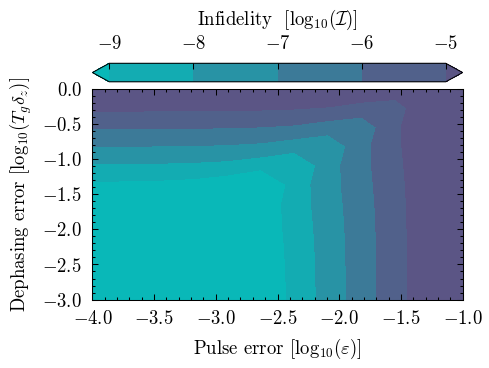

In [13]:
plottools.plot_noise_contour(multi_source_dict)

In [14]:
for idx, hadamard_opt_step in enumerate([0,200,len(barqcurve.params_history)-1]):

    barqcurve.update_params_from_opt_history(hadamard_opt_step)
    barqcurve.save_bezier_control_points('hadamard_step'+str(hadamard_opt_step)+'.csv')
# Since the parameters are updated, some attributes need re-evaluation.